
## INE Instituto nacional de estadística
### Precio Vivienda

In [1]:
%load_ext autoreload
%autoreload 2
import json
import os
import re
import sys
from datetime import date
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import requests

cwd = Path.cwd()
home = Path.home()
module_path = f"{home}/serhi/src/lib" if cwd == home else f"{cwd.parents[1]}/lib"
sys.path.append(module_path)
import serhi

SerHi Tools


In [2]:
# inicio
# cambiar como corresponda

ENTITY = "ine"
NB_NAME = "ine_ipv"
serhi.initialize(ENTITY, NB_NAME)

serhi.CWD /home/runner/work/serhi/serhi/src/entidades/ine
serhi.HOME /home/runner
serhi.BASE_PATH /home/runner/work/serhi/serhi
serhi.DATA_PATH /home/runner/work/serhi/serhi/data/process/ine/
serhi.DOWN_PATH /home/runner/work/serhi/serhi/tmp/download/ine/
serhi.OUT_FILE /home/runner/work/serhi/serhi/data/process/ine/ine_ipv.csv


In [3]:
def download_files(urls):
    for loc in urls:
        url = loc["url"]
        r = requests.get(url, allow_redirects=True)
        print(f"Downloading {url}")
        open(serhi.DOWN_PATH + loc["file"], "wb").write(r.content)


urls = [
    {
        # url - indices precios vivienda
        "url": "https://www.ine.es/jaxiT3/files/t/es/xlsx/25171.xlsx?nocab=1",
        # tmp file
        "file": "ine_ipv.xlsx",
    },
]

download_files(urls)

In [4]:
df = pd.DataFrame()
loc = urls[0]
file = loc['file']
df = pd.read_excel(serhi.DOWN_PATH + file, skiprows=6, nrows=76, header=(0,1))

/opt/hostedtoolcache/Python/3.9.16/x64/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [5]:
df.head()

Índice                                      \
                               2022T3   2022T2   2022T1   2021T4   2021T3   
0                   Nacional      NaN      NaN      NaN      NaN      NaN   
1                    General   143.86  141.433  138.742  135.291  133.652   
2             Vivienda nueva  154.931   153.51  153.365   148.64  145.073   
3      Vivienda segunda mano  142.339  139.707  136.511  133.292  132.009   
4               01 Andalucía      NaN      NaN      NaN      NaN      NaN   

                                       ... Variación en lo que va de año  \
    2021T2   2021T1   2020T4   2020T3  ...                        2009T2   
0      NaN      NaN      NaN      NaN  ...                           NaN   
1  130.937  127.831  127.179  128.255  ...                          -3.1   
2  141.088  139.321  140.144    139.4  ...                          -3.1   
3  129.522  126.153  125.222   126.58  ...                          -3.2   
4      NaN      NaN      NaN      NaN  ...                           NaN   

                                                                  
  2009T1 2008T4 2008T3 2008T2 2008T1 2007T4 2007T3 2007T2 2007T1  
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
1   -2.7   -5.4   -2.3   -0.7   -0.4    5.7    6.5    5.3    2.4  
2   -2.4    0.8    2.2    1.6    0.4    9.8    8.2      6    2.9  
3     -3  -10.7   -6.2   -2.7     -1    2.4    5.1    4.8      2  
4    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[5 rows x 253 columns]

In [6]:
df.columns.levels[0]

Index([' ', 'Variación anual', 'Variación en lo que va de año',
       'Variación trimestral', 'Índice'],
      dtype='object')

In [7]:
df = df.rename(columns={" ": "Name"})

In [8]:
def ine_sheet_ccaa(df, set_name, nccaa=17, ndatos=4, uni="idx"):
    dr = pd.DataFrame()
    for i in range(0, nccaa):
        # get next rows
        dt = df.iloc[i * ndatos : (i * ndatos) + ndatos].copy()
        dt.reset_index(inplace=True, drop=True)
        # save zone
        zone = dt.iloc[0][0]
        # delete first row
        dt = dt.loc[1:]
        # change columns names - to months
        # columns = [w.replace('M','-') for w in dt.columns]
        # columns = [w + '-01' for w in columns]
        # columns[0] = 'Name'
        # dt.columns = columns
        dt = dt.T
        # promote columns
        dt.columns = dt.iloc[0]
        dt = dt[1:]
        dt.columns = [w.strip() for w in dt.columns]
        # change index name
        dt.index.rename("Date", inplace=True)
        # sort
        dt.sort_index(ascending=True, inplace=True)
        # transpose
        dt = dt.unstack()
        dt = dt.reset_index()
        # set zone
        dt["Zone"] = zone
        dt["Ud"] = uni
        # set column value
        dt = dt.rename(columns={0: "Value"})
        # concat
        dr = pd.concat([dr, dt])

    dr["Set"] = set_name
    dr.rename(columns={"level_0": "Name"}, inplace=True)
    return dr


def quarter_to_dates(qcolumns):
    qcolumns = [w.replace("T1", "-01") for w in qcolumns]
    qcolumns = [w.replace("T2", "-04") for w in qcolumns]
    qcolumns = [w.replace("T3", "-07") for w in qcolumns]
    qcolumns = [w.replace("T4", "-10") for w in qcolumns]
    return qcolumns

In [9]:
dt = pd.DataFrame()
unidades = ["idx_va", "idx_vaa", "idx_vt", "idx"]
series = df.columns.levels[0][1:]

for i, s in enumerate(series):
    print(i, s, unidades[i])
    dts = df[["Name", s]].copy()
    dts.columns = dts.columns.droplevel()
    dts.columns = quarter_to_dates(dts.columns)
    dtt = ine_sheet_ccaa(dts, "INE_IPV", 18, 4, uni=unidades[i])
    dt = pd.concat([dt, dtt])

0 Variación anual idx_va
1 Variación en lo que va de año idx_vaa
2 Variación trimestral idx_vt
3 Índice idx


In [10]:
dt['Name'].unique()

array(['General', 'Vivienda nueva', 'Vivienda segunda mano'], dtype=object)

In [11]:
dt['Zone'].unique()

array(['Nacional', '01 Andalucía', '02 Aragón',
       '03 Asturias, Principado de', '04 Balears, Illes', '05 Canarias',
       '06 Cantabria', '07 Castilla y León', '08 Castilla - La Mancha',
       '09 Cataluña', '10 Comunitat Valenciana', '11 Extremadura',
       '12 Galicia', '13 Madrid, Comunidad de', '14 Murcia, Región de',
       '15 Navarra, Comunidad Foral de', '16 País Vasco', '17 Rioja, La'],
      dtype=object)

In [12]:
#dt = df[df['Value'].notnull()]

In [13]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13608 entries, 0 to 188
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    13608 non-null  object
 1   Date    13608 non-null  object
 2   Value   13608 non-null  object
 3   Zone    13608 non-null  object
 4   Ud      13608 non-null  object
 5   Set     13608 non-null  object
dtypes: object(6)
memory usage: 744.2+ KB


In [14]:
dt['Date'] = pd.to_datetime(dt['Date'])
dt['Date'].agg(['min', 'max'])

min   2007-01-01
max   2022-07-01
Name: Date, dtype: datetime64[ns]

Nacional


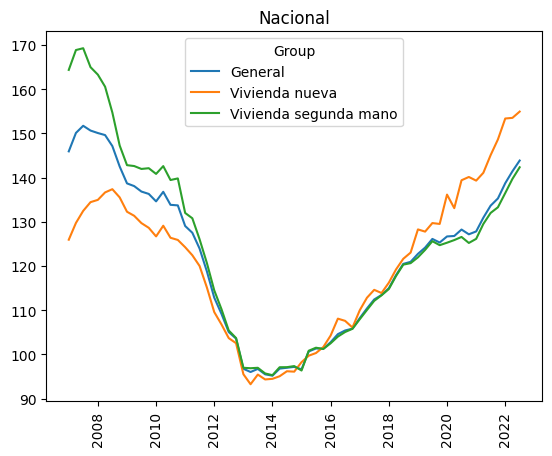

01 Andalucía


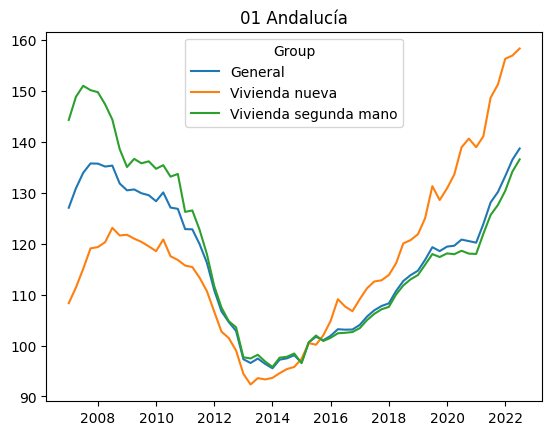

02 Aragón


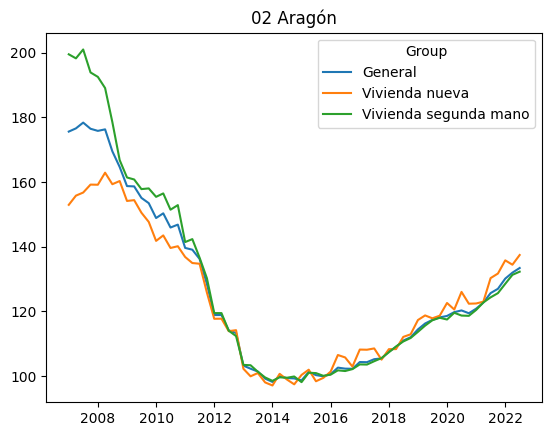

03 Asturias, Principado de


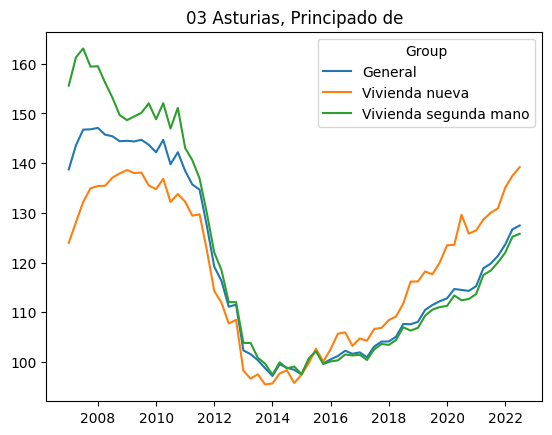

04 Balears, Illes


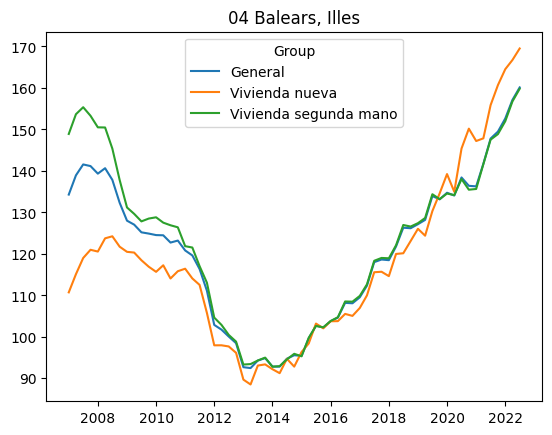

05 Canarias


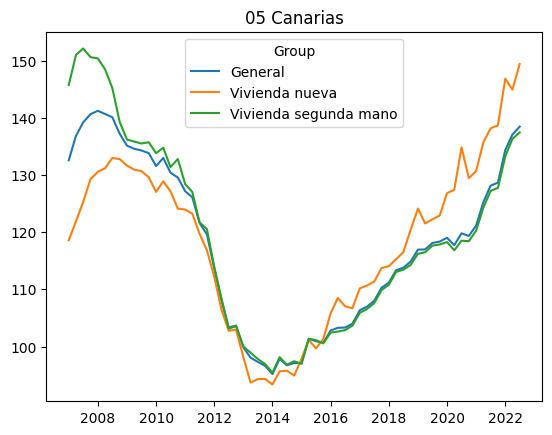

06 Cantabria


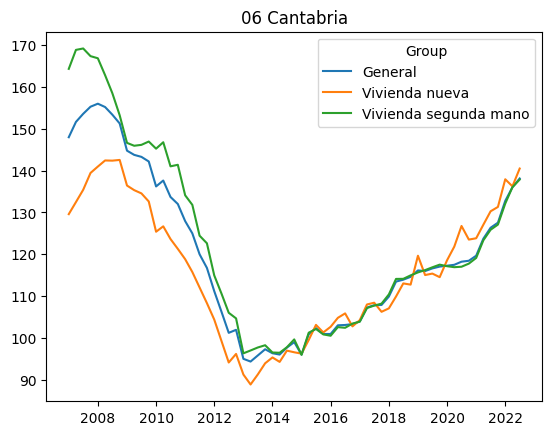

07 Castilla y León


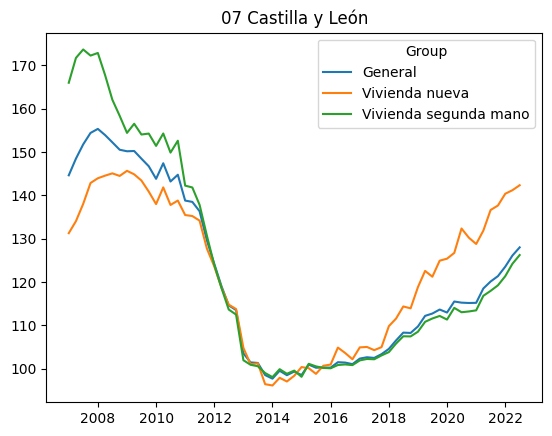

08 Castilla - La Mancha


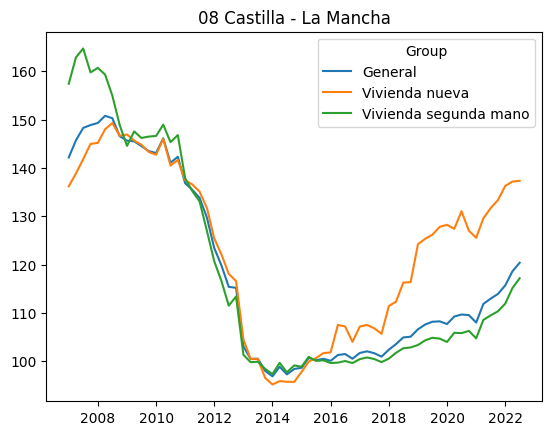

09 Cataluña


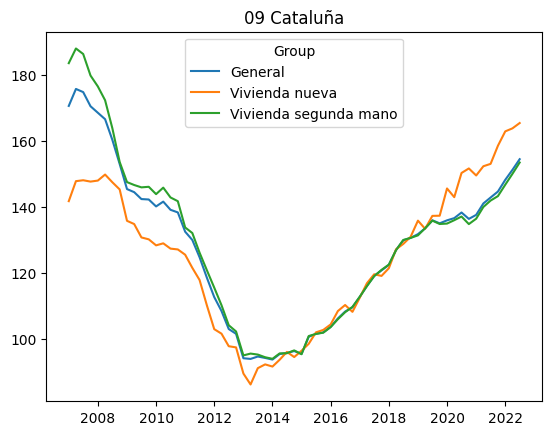

10 Comunitat Valenciana


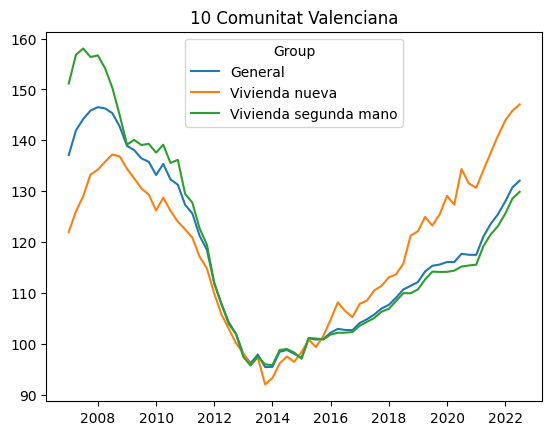

11 Extremadura


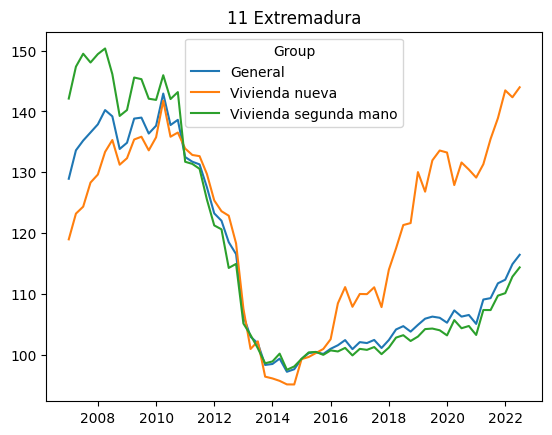

12 Galicia


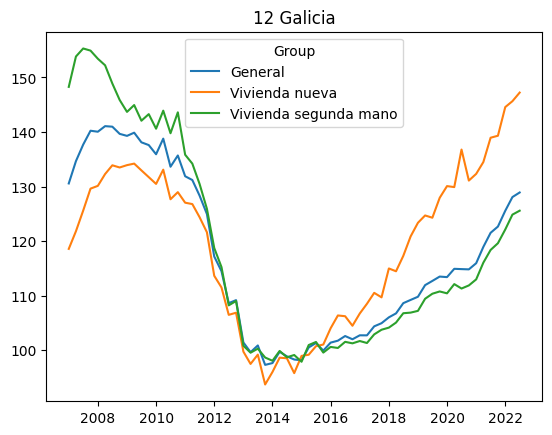

13 Madrid, Comunidad de


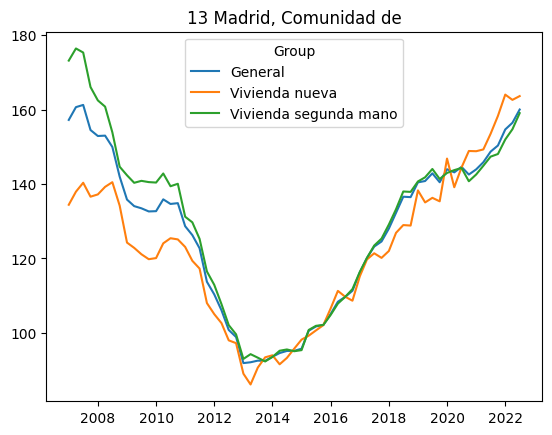

14 Murcia, Región de


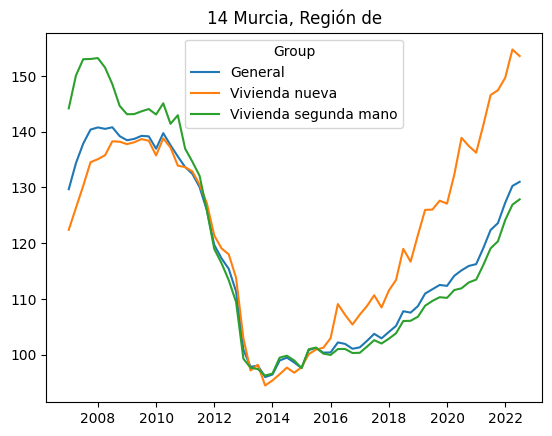

15 Navarra, Comunidad Foral de


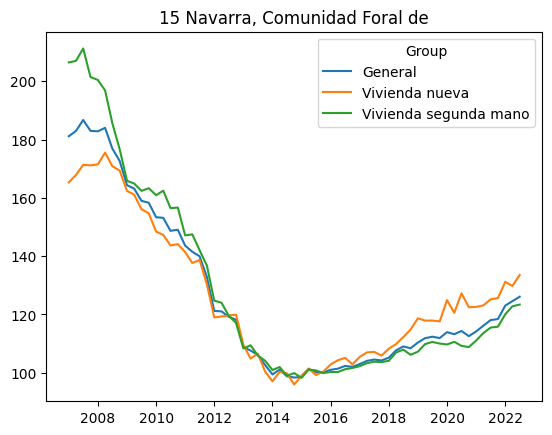

16 País Vasco


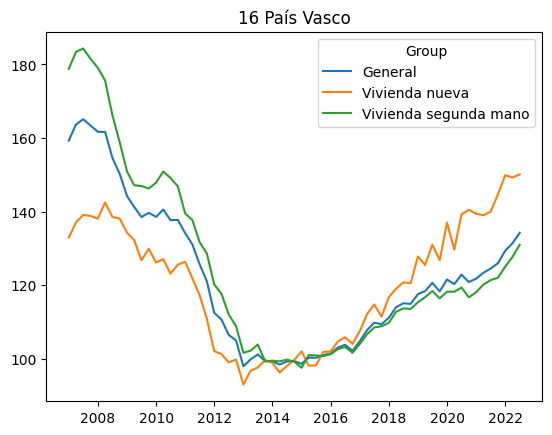

17 Rioja, La


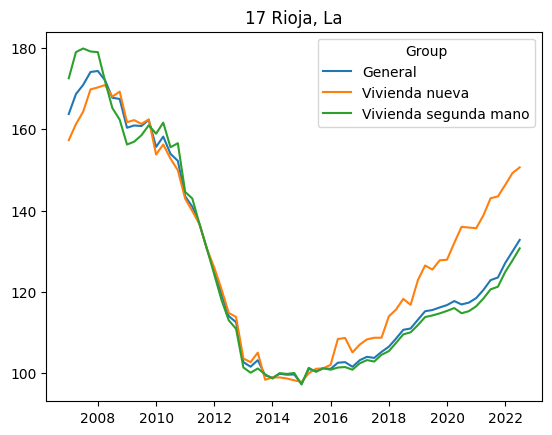

In [15]:
names = dt['Name'].unique()
zones = dt['Zone'].unique()

fig, ax = plt.subplots()
for z in zones:
    print(z)
    dx = dt[(dt['Zone'] == z) & (dt['Ud'] == 'idx')]
    plt.title(z)
    for n in names:
        dxz = dx[dx['Name'] == n]
        plt.plot(dxz['Date'], dxz['Value'], label=f'{n}')
    plt.legend(title='Group')
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.show()

In [16]:
# Guardamos la serie procesada
df.to_csv(serhi.OUT_FILE, index=False)